<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:23:50] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


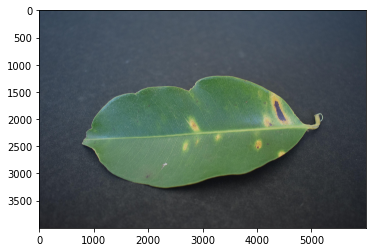

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

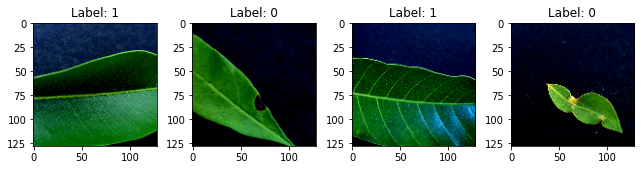

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:23:55] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:23:57] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2544710846530147 samples/sec                   batch loss = 2.528486490249634 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2631919109173928 samples/sec                   batch loss = 1.0196948051452637 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.261197408718846 samples/sec                   batch loss = 0.5607864856719971 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.259980771215161 samples/sec                   batch loss = 0.5852208137512207 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2585340970807366 samples/sec                   batch loss = 0.7736453413963318 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2604165774537313 samples/sec                   batch loss = 1.484807014465332 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2622776305419554 samples/sec                   batch loss = 0.3364790976047516 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2597880486647222 samples/sec                   batch loss = 0.5529112815856934 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2640654192334229 samples/sec                   batch loss = 0.5232288837432861 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.254094404427942 samples/sec                   batch loss = 0.6322214007377625 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.2468492694799946 samples/sec                   batch loss = 0.415548712015152 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2718784228152507 samples/sec                   batch loss = 2.3923184871673584 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2660111142225843 samples/sec                   batch loss = 0.6076850891113281 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2692339960898382 samples/sec                   batch loss = 1.2660248279571533 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2646068997788757 samples/sec                   batch loss = 0.4974817633628845 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.266936648999105 samples/sec                   batch loss = 1.2649438381195068 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2712675041400718 samples/sec                   batch loss = 0.6509572267532349 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2677550868046281 samples/sec                   batch loss = 0.4231428802013397 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.261252305099297 samples/sec                   batch loss = 0.5595105290412903 | accuracy = 0.5947368421052631


Epoch[1] Batch[100] Speed: 1.26061849082684 samples/sec                   batch loss = 0.8347467184066772 | accuracy = 0.605


Epoch[1] Batch[105] Speed: 1.2627111309070707 samples/sec                   batch loss = 0.7281294465065002 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2673717283277088 samples/sec                   batch loss = 0.9641739726066589 | accuracy = 0.5977272727272728


Epoch[1] Batch[115] Speed: 1.2723085091143271 samples/sec                   batch loss = 0.6482077240943909 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.273813541518217 samples/sec                   batch loss = 0.40304863452911377 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.271770922568212 samples/sec                   batch loss = 0.5993716716766357 | accuracy = 0.6


Epoch[1] Batch[130] Speed: 1.2672077489243374 samples/sec                   batch loss = 0.3732739984989166 | accuracy = 0.6057692307692307


Epoch[1] Batch[135] Speed: 1.2703123563752323 samples/sec                   batch loss = 1.0433008670806885 | accuracy = 0.6037037037037037


Epoch[1] Batch[140] Speed: 1.264163428751063 samples/sec                   batch loss = 0.5032998919487 | accuracy = 0.6107142857142858


Epoch[1] Batch[145] Speed: 1.2676753889095964 samples/sec                   batch loss = 0.45498186349868774 | accuracy = 0.6172413793103448


Epoch[1] Batch[150] Speed: 1.2696935239804157 samples/sec                   batch loss = 1.123262882232666 | accuracy = 0.615


Epoch[1] Batch[155] Speed: 1.2707011533715864 samples/sec                   batch loss = 0.574877917766571 | accuracy = 0.617741935483871


Epoch[1] Batch[160] Speed: 1.2642552609809143 samples/sec                   batch loss = 1.3984564542770386 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.2669230635628195 samples/sec                   batch loss = 0.3873726725578308 | accuracy = 0.6196969696969697


Epoch[1] Batch[170] Speed: 1.2721929292098242 samples/sec                   batch loss = 0.5229141116142273 | accuracy = 0.6294117647058823


Epoch[1] Batch[175] Speed: 1.2686103621228386 samples/sec                   batch loss = 0.42020994424819946 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.2635408648195876 samples/sec                   batch loss = 0.6316869258880615 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2652587585631243 samples/sec                   batch loss = 0.6610884666442871 | accuracy = 0.6243243243243243


Epoch[1] Batch[190] Speed: 1.264887588775464 samples/sec                   batch loss = 0.47494709491729736 | accuracy = 0.625


Epoch[1] Batch[195] Speed: 1.2655089034801084 samples/sec                   batch loss = 0.5774554014205933 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2635032773694768 samples/sec                   batch loss = 0.5842735767364502 | accuracy = 0.63125


Epoch[1] Batch[205] Speed: 1.2648143535469831 samples/sec                   batch loss = 0.27997300028800964 | accuracy = 0.6378048780487805


Epoch[1] Batch[210] Speed: 1.267694450354953 samples/sec                   batch loss = 0.6749818325042725 | accuracy = 0.6357142857142857


Epoch[1] Batch[215] Speed: 1.2673175424644487 samples/sec                   batch loss = 1.1536718606948853 | accuracy = 0.6372093023255814


Epoch[1] Batch[220] Speed: 1.261429257564042 samples/sec                   batch loss = 0.7810945510864258 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.261811591249005 samples/sec                   batch loss = 0.6136724352836609 | accuracy = 0.64


Epoch[1] Batch[230] Speed: 1.2699468675968186 samples/sec                   batch loss = 0.45007917284965515 | accuracy = 0.6413043478260869


Epoch[1] Batch[235] Speed: 1.264669815146655 samples/sec                   batch loss = 0.4123730957508087 | accuracy = 0.6414893617021277


Epoch[1] Batch[240] Speed: 1.2607055456728795 samples/sec                   batch loss = 0.8246949315071106 | accuracy = 0.6427083333333333


Epoch[1] Batch[245] Speed: 1.2564476457805374 samples/sec                   batch loss = 0.5375723242759705 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.261241306477917 samples/sec                   batch loss = 0.7423716187477112 | accuracy = 0.643


Epoch[1] Batch[255] Speed: 1.2671098410049502 samples/sec                   batch loss = 0.38016459345817566 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.2745296315397998 samples/sec                   batch loss = 0.8016245365142822 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.2719472710839017 samples/sec                   batch loss = 1.4522716999053955 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2725445580173713 samples/sec                   batch loss = 0.8472820520401001 | accuracy = 0.6453703703703704


Epoch[1] Batch[275] Speed: 1.2691451834377967 samples/sec                   batch loss = 0.3745027184486389 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2622094452255777 samples/sec                   batch loss = 0.5740110874176025 | accuracy = 0.6526785714285714


Epoch[1] Batch[285] Speed: 1.2648692791732685 samples/sec                   batch loss = 0.44135782122612 | accuracy = 0.6543859649122807


Epoch[1] Batch[290] Speed: 1.2734221612983168 samples/sec                   batch loss = 0.4321453273296356 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.265438459692265 samples/sec                   batch loss = 0.6896094083786011 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.2680588352980044 samples/sec                   batch loss = 0.4180178642272949 | accuracy = 0.6541666666666667


Epoch[1] Batch[305] Speed: 1.2605065402444797 samples/sec                   batch loss = 0.8528140783309937 | accuracy = 0.6532786885245901


Epoch[1] Batch[310] Speed: 1.2661686683702655 samples/sec                   batch loss = 0.8123105764389038 | accuracy = 0.6556451612903226


Epoch[1] Batch[315] Speed: 1.267559595764228 samples/sec                   batch loss = 0.6371986865997314 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.260237731694432 samples/sec                   batch loss = 0.8937134146690369 | accuracy = 0.653125


Epoch[1] Batch[325] Speed: 1.2629842283703845 samples/sec                   batch loss = 0.4103253185749054 | accuracy = 0.6546153846153846


Epoch[1] Batch[330] Speed: 1.265337580283644 samples/sec                   batch loss = 0.4601367712020874 | accuracy = 0.6575757575757576


Epoch[1] Batch[335] Speed: 1.2657847405981968 samples/sec                   batch loss = 0.49695828557014465 | accuracy = 0.6582089552238806


Epoch[1] Batch[340] Speed: 1.2657458736099192 samples/sec                   batch loss = 0.264978289604187 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.260344048386011 samples/sec                   batch loss = 0.3091278374195099 | accuracy = 0.6630434782608695


Epoch[1] Batch[350] Speed: 1.2643150924738462 samples/sec                   batch loss = 0.3311493694782257 | accuracy = 0.6664285714285715


Epoch[1] Batch[355] Speed: 1.2677587270920188 samples/sec                   batch loss = 0.4956480860710144 | accuracy = 0.6676056338028169


Epoch[1] Batch[360] Speed: 1.2683258133373814 samples/sec                   batch loss = 0.3263971507549286 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2590473208685475 samples/sec                   batch loss = 0.42621830105781555 | accuracy = 0.6684931506849315


Epoch[1] Batch[370] Speed: 1.26261049581038 samples/sec                   batch loss = 0.2482130229473114 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.2656890576150808 samples/sec                   batch loss = 0.3472480773925781 | accuracy = 0.672


Epoch[1] Batch[380] Speed: 1.2727229555922737 samples/sec                   batch loss = 0.5654968023300171 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2701467497622811 samples/sec                   batch loss = 0.5502726435661316 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2623053626107361 samples/sec                   batch loss = 0.5837679505348206 | accuracy = 0.6724358974358975


Epoch[1] Batch[395] Speed: 1.2630633374782438 samples/sec                   batch loss = 0.40783023834228516 | accuracy = 0.6727848101265823


Epoch[1] Batch[400] Speed: 1.26218475598063 samples/sec                   batch loss = 0.3575240671634674 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.271940424493753 samples/sec                   batch loss = 0.56166011095047 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.2686730049339756 samples/sec                   batch loss = 0.6691681146621704 | accuracy = 0.6737804878048781


Epoch[1] Batch[415] Speed: 1.269033153206115 samples/sec                   batch loss = 0.36333075165748596 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.274620555124787 samples/sec                   batch loss = 0.4637032449245453 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.268441842421889 samples/sec                   batch loss = 0.5910255312919617 | accuracy = 0.6770588235294117


Epoch[1] Batch[430] Speed: 1.269805959163439 samples/sec                   batch loss = 0.49102094769477844 | accuracy = 0.6784883720930233


Epoch[1] Batch[435] Speed: 1.2639723766412896 samples/sec                   batch loss = 0.568366527557373 | accuracy = 0.6793103448275862


Epoch[1] Batch[440] Speed: 1.2713749192944592 samples/sec                   batch loss = 0.4543887972831726 | accuracy = 0.6795454545454546


Epoch[1] Batch[445] Speed: 1.2632834118046845 samples/sec                   batch loss = 0.33901816606521606 | accuracy = 0.6786516853932584


Epoch[1] Batch[450] Speed: 1.266448139174797 samples/sec                   batch loss = 0.2849528193473816 | accuracy = 0.6788888888888889


Epoch[1] Batch[455] Speed: 1.2600506086648788 samples/sec                   batch loss = 0.4926074743270874 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.2576517155439388 samples/sec                   batch loss = 0.4765075743198395 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.263675722252518 samples/sec                   batch loss = 0.517367422580719 | accuracy = 0.6790322580645162


Epoch[1] Batch[470] Speed: 1.2689817046462497 samples/sec                   batch loss = 0.3850155770778656 | accuracy = 0.6787234042553192


Epoch[1] Batch[475] Speed: 1.2646469361067918 samples/sec                   batch loss = 0.8788703680038452 | accuracy = 0.6752631578947368


Epoch[1] Batch[480] Speed: 1.262147913826582 samples/sec                   batch loss = 0.7360457181930542 | accuracy = 0.6765625


Epoch[1] Batch[485] Speed: 1.26035664095428 samples/sec                   batch loss = 0.27315574884414673 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2595654078557221 samples/sec                   batch loss = 0.43466708064079285 | accuracy = 0.6795918367346939


Epoch[1] Batch[495] Speed: 1.2558185560540573 samples/sec                   batch loss = 0.31236532330513 | accuracy = 0.6797979797979798


Epoch[1] Batch[500] Speed: 1.257918478754745 samples/sec                   batch loss = 0.35235536098480225 | accuracy = 0.681


Epoch[1] Batch[505] Speed: 1.2624629456808552 samples/sec                   batch loss = 0.9074851870536804 | accuracy = 0.6801980198019802


Epoch[1] Batch[510] Speed: 1.2594076018686764 samples/sec                   batch loss = 0.7973690032958984 | accuracy = 0.6803921568627451


Epoch[1] Batch[515] Speed: 1.2580887420691824 samples/sec                   batch loss = 0.30030104517936707 | accuracy = 0.6820388349514563


Epoch[1] Batch[520] Speed: 1.2675142037277145 samples/sec                   batch loss = 0.6841099262237549 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.262495056037594 samples/sec                   batch loss = 0.546423614025116 | accuracy = 0.6842857142857143


Epoch[1] Batch[530] Speed: 1.2605129801788633 samples/sec                   batch loss = 1.1248164176940918 | accuracy = 0.6834905660377358


Epoch[1] Batch[535] Speed: 1.2723772109610962 samples/sec                   batch loss = 0.41661518812179565 | accuracy = 0.6836448598130841


Epoch[1] Batch[540] Speed: 1.2661804220099278 samples/sec                   batch loss = 0.6754136681556702 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.2690506236285757 samples/sec                   batch loss = 1.2758846282958984 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2721466259582965 samples/sec                   batch loss = 0.3327357769012451 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.272417354799952 samples/sec                   batch loss = 0.6060487031936646 | accuracy = 0.686036036036036


Epoch[1] Batch[560] Speed: 1.2645637205809186 samples/sec                   batch loss = 0.5093993544578552 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2710394395952667 samples/sec                   batch loss = 0.30945518612861633 | accuracy = 0.6871681415929204


Epoch[1] Batch[570] Speed: 1.2656640410970013 samples/sec                   batch loss = 0.7508335709571838 | accuracy = 0.6859649122807018


Epoch[1] Batch[575] Speed: 1.266245214281903 samples/sec                   batch loss = 0.1757621169090271 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2650582177921583 samples/sec                   batch loss = 0.555683970451355 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.2704680005512838 samples/sec                   batch loss = 0.4155409336090088 | accuracy = 0.6897435897435897


Epoch[1] Batch[590] Speed: 1.2705469915717251 samples/sec                   batch loss = 0.47444671392440796 | accuracy = 0.690677966101695


Epoch[1] Batch[595] Speed: 1.2690440001700407 samples/sec                   batch loss = 0.27237746119499207 | accuracy = 0.6928571428571428


Epoch[1] Batch[600] Speed: 1.2614795264290732 samples/sec                   batch loss = 0.22189272940158844 | accuracy = 0.6929166666666666


Epoch[1] Batch[605] Speed: 1.2673791002608077 samples/sec                   batch loss = 0.7535521984100342 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.265845863049117 samples/sec                   batch loss = 0.1624770164489746 | accuracy = 0.6913934426229508


Epoch[1] Batch[615] Speed: 1.2659775828945443 samples/sec                   batch loss = 0.5751714706420898 | accuracy = 0.6914634146341463


Epoch[1] Batch[620] Speed: 1.2683115269262693 samples/sec                   batch loss = 0.2902374565601349 | accuracy = 0.6919354838709677


Epoch[1] Batch[625] Speed: 1.268560962124979 samples/sec                   batch loss = 0.624167263507843 | accuracy = 0.6908


Epoch[1] Batch[630] Speed: 1.2698298902466936 samples/sec                   batch loss = 0.28525489568710327 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.26683964389103 samples/sec                   batch loss = 0.564507246017456 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2631418858916539 samples/sec                   batch loss = 0.6216612458229065 | accuracy = 0.6890625


Epoch[1] Batch[645] Speed: 1.2710378026034084 samples/sec                   batch loss = 0.38349851965904236 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.2691430712882033 samples/sec                   batch loss = 0.3214588761329651 | accuracy = 0.6896153846153846


Epoch[1] Batch[655] Speed: 1.270560654839606 samples/sec                   batch loss = 0.4294514060020447 | accuracy = 0.6889312977099237


Epoch[1] Batch[660] Speed: 1.2719215244302904 samples/sec                   batch loss = 0.2736191749572754 | accuracy = 0.690530303030303


Epoch[1] Batch[665] Speed: 1.2703942139161235 samples/sec                   batch loss = 0.2382635623216629 | accuracy = 0.6917293233082706


Epoch[1] Batch[670] Speed: 1.2669874534589929 samples/sec                   batch loss = 0.6147547364234924 | accuracy = 0.6914179104477612


Epoch[1] Batch[675] Speed: 1.2654662353712758 samples/sec                   batch loss = 0.50568026304245 | accuracy = 0.6914814814814815


Epoch[1] Batch[680] Speed: 1.2702286821318065 samples/sec                   batch loss = 0.21455928683280945 | accuracy = 0.6915441176470588


Epoch[1] Batch[685] Speed: 1.2638715404156085 samples/sec                   batch loss = 0.5756015777587891 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.2682590822569988 samples/sec                   batch loss = 0.3057016134262085 | accuracy = 0.6920289855072463


Epoch[1] Batch[695] Speed: 1.2645471359774292 samples/sec                   batch loss = 0.47419852018356323 | accuracy = 0.6924460431654677


Epoch[1] Batch[700] Speed: 1.266288221663477 samples/sec                   batch loss = 0.7532945871353149 | accuracy = 0.6907142857142857


Epoch[1] Batch[705] Speed: 1.2676114079477918 samples/sec                   batch loss = 0.4589916467666626 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.2667202733791332 samples/sec                   batch loss = 0.3911862373352051 | accuracy = 0.6926056338028169


Epoch[1] Batch[715] Speed: 1.267068500268485 samples/sec                   batch loss = 0.576808512210846 | accuracy = 0.6933566433566434


Epoch[1] Batch[720] Speed: 1.266921341486069 samples/sec                   batch loss = 0.5365152955055237 | accuracy = 0.6947916666666667


Epoch[1] Batch[725] Speed: 1.2673009812788283 samples/sec                   batch loss = 0.6342057585716248 | accuracy = 0.6955172413793104


Epoch[1] Batch[730] Speed: 1.2702442620178005 samples/sec                   batch loss = 0.05210070312023163 | accuracy = 0.6962328767123288


Epoch[1] Batch[735] Speed: 1.263913815401349 samples/sec                   batch loss = 0.472678005695343 | accuracy = 0.6959183673469388


Epoch[1] Batch[740] Speed: 1.2738355928179284 samples/sec                   batch loss = 0.7369797825813293 | accuracy = 0.6962837837837837


Epoch[1] Batch[745] Speed: 1.2665250057146515 samples/sec                   batch loss = 0.33618593215942383 | accuracy = 0.696979865771812


Epoch[1] Batch[750] Speed: 1.263380824404676 samples/sec                   batch loss = 0.4437703490257263 | accuracy = 0.6966666666666667


Epoch[1] Batch[755] Speed: 1.2627740478699383 samples/sec                   batch loss = 0.5653872489929199 | accuracy = 0.6963576158940398


Epoch[1] Batch[760] Speed: 1.2728131387644335 samples/sec                   batch loss = 0.3431435525417328 | accuracy = 0.6963815789473684


Epoch[1] Batch[765] Speed: 1.2739361873783608 samples/sec                   batch loss = 0.7530408501625061 | accuracy = 0.6964052287581699


Epoch[1] Batch[770] Speed: 1.2682436469007803 samples/sec                   batch loss = 0.4937482178211212 | accuracy = 0.6964285714285714


Epoch[1] Batch[775] Speed: 1.264377978808885 samples/sec                   batch loss = 0.46659499406814575 | accuracy = 0.6974193548387096


Epoch[1] Batch[780] Speed: 1.2651422616323043 samples/sec                   batch loss = 0.436177134513855 | accuracy = 0.6977564102564102


Epoch[1] Batch[785] Speed: 1.2722605573061943 samples/sec                   batch loss = 0.2940819263458252 | accuracy = 0.697452229299363


[Epoch 1] training: accuracy=0.6970177664974619
[Epoch 1] time cost: 649.6634075641632
[Epoch 1] validation: validation accuracy=0.7511111111111111


Epoch[2] Batch[5] Speed: 1.2652223092238322 samples/sec                   batch loss = 0.6672205924987793 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2649435698574696 samples/sec                   batch loss = 0.8286502957344055 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.264762197689202 samples/sec                   batch loss = 0.6492536067962646 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2651359651120457 samples/sec                   batch loss = 0.6450285315513611 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2694143480184354 samples/sec                   batch loss = 0.11785952746868134 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.2620389192235533 samples/sec                   batch loss = 1.8342809677124023 | accuracy = 0.6833333333333333


Epoch[2] Batch[35] Speed: 1.267789766180925 samples/sec                   batch loss = 0.7524283528327942 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2628896337343536 samples/sec                   batch loss = 0.1333746463060379 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.26352877949677 samples/sec                   batch loss = 0.27813899517059326 | accuracy = 0.7055555555555556


Epoch[2] Batch[50] Speed: 1.2644336289041722 samples/sec                   batch loss = 0.2709351181983948 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2608343027887248 samples/sec                   batch loss = 0.6615394353866577 | accuracy = 0.7227272727272728


Epoch[2] Batch[60] Speed: 1.2685406277097062 samples/sec                   batch loss = 0.22594068944454193 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2695790911786238 samples/sec                   batch loss = 0.45982128381729126 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2668123818159756 samples/sec                   batch loss = 0.25674349069595337 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2624603807228085 samples/sec                   batch loss = 0.3697212338447571 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2673352528817587 samples/sec                   batch loss = 0.43744775652885437 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2658101439000198 samples/sec                   batch loss = 0.45756375789642334 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2642680270981064 samples/sec                   batch loss = 0.4883413314819336 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2636426000469387 samples/sec                   batch loss = 0.32967278361320496 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2687606001250367 samples/sec                   batch loss = 0.36825719475746155 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2641293284777086 samples/sec                   batch loss = 0.39936140179634094 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2586106668525139 samples/sec                   batch loss = 0.783920168876648 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.273052659327011 samples/sec                   batch loss = 0.1782248467206955 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2723647630255879 samples/sec                   batch loss = 0.35627955198287964 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2653674511285737 samples/sec                   batch loss = 0.10961519181728363 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2644110442851686 samples/sec                   batch loss = 1.5648893117904663 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.268150275800426 samples/sec                   batch loss = 0.2810356318950653 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2738745713247441 samples/sec                   batch loss = 0.21963238716125488 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2621270249009031 samples/sec                   batch loss = 0.6893499493598938 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2672715934196088 samples/sec                   batch loss = 1.2851476669311523 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2702966786375527 samples/sec                   batch loss = 0.48934492468833923 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2691218541754872 samples/sec                   batch loss = 0.34383082389831543 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.274782390525473 samples/sec                   batch loss = 0.777553915977478 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2688863054843211 samples/sec                   batch loss = 0.9766485691070557 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2733267698308395 samples/sec                   batch loss = 0.3579445481300354 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.2748948569137593 samples/sec                   batch loss = 0.47775623202323914 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.2656241312949128 samples/sec                   batch loss = 0.48643186688423157 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2771987221630292 samples/sec                   batch loss = 0.49240925908088684 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2771955136049602 samples/sec                   batch loss = 0.5546474456787109 | accuracy = 0.7602564102564102


Epoch[2] Batch[200] Speed: 1.2700818460576453 samples/sec                   batch loss = 0.16320443153381348 | accuracy = 0.7625


Epoch[2] Batch[205] Speed: 1.2641038973485805 samples/sec                   batch loss = 1.0174729824066162 | accuracy = 0.7585365853658537


Epoch[2] Batch[210] Speed: 1.272182800085534 samples/sec                   batch loss = 0.2977370321750641 | accuracy = 0.7607142857142857


Epoch[2] Batch[215] Speed: 1.2650422879258596 samples/sec                   batch loss = 0.6009277701377869 | accuracy = 0.7627906976744186


Epoch[2] Batch[220] Speed: 1.266557801120297 samples/sec                   batch loss = 0.24202322959899902 | accuracy = 0.7625


Epoch[2] Batch[225] Speed: 1.2701212682577108 samples/sec                   batch loss = 0.41179540753364563 | accuracy = 0.7633333333333333


Epoch[2] Batch[230] Speed: 1.272410020640277 samples/sec                   batch loss = 0.49827003479003906 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.267601255873923 samples/sec                   batch loss = 0.36298567056655884 | accuracy = 0.7617021276595745


Epoch[2] Batch[240] Speed: 1.2689608768446854 samples/sec                   batch loss = 0.4726027250289917 | accuracy = 0.7645833333333333


Epoch[2] Batch[245] Speed: 1.2693596992374256 samples/sec                   batch loss = 0.2804681062698364 | accuracy = 0.7663265306122449


Epoch[2] Batch[250] Speed: 1.2737785318124313 samples/sec                   batch loss = 0.5245132446289062 | accuracy = 0.768


Epoch[2] Batch[255] Speed: 1.2690835499630635 samples/sec                   batch loss = 0.36721304059028625 | accuracy = 0.7676470588235295


Epoch[2] Batch[260] Speed: 1.2696073371568124 samples/sec                   batch loss = 0.447829008102417 | accuracy = 0.7692307692307693


Epoch[2] Batch[265] Speed: 1.27023262515325 samples/sec                   batch loss = 0.5980761051177979 | accuracy = 0.7679245283018868


Epoch[2] Batch[270] Speed: 1.2715919243697147 samples/sec                   batch loss = 0.5146860480308533 | accuracy = 0.7694444444444445


Epoch[2] Batch[275] Speed: 1.2696108920118159 samples/sec                   batch loss = 0.11173979938030243 | accuracy = 0.769090909090909


Epoch[2] Batch[280] Speed: 1.2651770844291412 samples/sec                   batch loss = 0.5016211867332458 | accuracy = 0.7669642857142858


Epoch[2] Batch[285] Speed: 1.2674142377957898 samples/sec                   batch loss = 0.36220717430114746 | accuracy = 0.7657894736842106


Epoch[2] Batch[290] Speed: 1.2717156851152132 samples/sec                   batch loss = 0.4507697820663452 | accuracy = 0.7637931034482759


Epoch[2] Batch[295] Speed: 1.271034817511463 samples/sec                   batch loss = 0.5176140666007996 | accuracy = 0.7627118644067796


Epoch[2] Batch[300] Speed: 1.2661859644523075 samples/sec                   batch loss = 0.2677648365497589 | accuracy = 0.7616666666666667


Epoch[2] Batch[305] Speed: 1.2662490370419681 samples/sec                   batch loss = 0.25186362862586975 | accuracy = 0.7614754098360655


Epoch[2] Batch[310] Speed: 1.2707606340284516 samples/sec                   batch loss = 0.5908770561218262 | accuracy = 0.760483870967742


Epoch[2] Batch[315] Speed: 1.2737221528231293 samples/sec                   batch loss = 0.5416686534881592 | accuracy = 0.7619047619047619


Epoch[2] Batch[320] Speed: 1.2739937462193391 samples/sec                   batch loss = 0.3252306878566742 | accuracy = 0.7625


Epoch[2] Batch[325] Speed: 1.2732171887647485 samples/sec                   batch loss = 0.49199438095092773 | accuracy = 0.7615384615384615


Epoch[2] Batch[330] Speed: 1.2700328121019844 samples/sec                   batch loss = 0.9196977019309998 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2679964447884104 samples/sec                   batch loss = 0.3142130672931671 | accuracy = 0.7611940298507462


Epoch[2] Batch[340] Speed: 1.2733274463157502 samples/sec                   batch loss = 0.5530087351799011 | accuracy = 0.7602941176470588


Epoch[2] Batch[345] Speed: 1.2715089487627975 samples/sec                   batch loss = 0.5118870139122009 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.2672451742275395 samples/sec                   batch loss = 0.7505888342857361 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.2710438691237895 samples/sec                   batch loss = 0.4359326660633087 | accuracy = 0.7619718309859155


Epoch[2] Batch[360] Speed: 1.2663218650295043 samples/sec                   batch loss = 0.23899127542972565 | accuracy = 0.7631944444444444


Epoch[2] Batch[365] Speed: 1.2672616382323918 samples/sec                   batch loss = 0.5790776014328003 | accuracy = 0.7643835616438356


Epoch[2] Batch[370] Speed: 1.2699758990033576 samples/sec                   batch loss = 0.31004035472869873 | accuracy = 0.7655405405405405


Epoch[2] Batch[375] Speed: 1.2727489278079884 samples/sec                   batch loss = 0.606929361820221 | accuracy = 0.766


Epoch[2] Batch[380] Speed: 1.2672174161182663 samples/sec                   batch loss = 0.387135773897171 | accuracy = 0.7651315789473684


Epoch[2] Batch[385] Speed: 1.2657080593717094 samples/sec                   batch loss = 0.0486639179289341 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.270841971771113 samples/sec                   batch loss = 0.11429081857204437 | accuracy = 0.7653846153846153


Epoch[2] Batch[395] Speed: 1.272986395830164 samples/sec                   batch loss = 0.8331331610679626 | accuracy = 0.7658227848101266


Epoch[2] Batch[400] Speed: 1.2689748899446778 samples/sec                   batch loss = 0.0791948214173317 | accuracy = 0.764375


Epoch[2] Batch[405] Speed: 1.2689818006284848 samples/sec                   batch loss = 0.5189452767372131 | accuracy = 0.762962962962963


Epoch[2] Batch[410] Speed: 1.27064254438482 samples/sec                   batch loss = 0.3251718580722809 | accuracy = 0.7646341463414634


Epoch[2] Batch[415] Speed: 1.2697317689276864 samples/sec                   batch loss = 0.16862063109874725 | accuracy = 0.7644578313253012


Epoch[2] Batch[420] Speed: 1.2703162037319573 samples/sec                   batch loss = 1.709131121635437 | accuracy = 0.7648809523809523


Epoch[2] Batch[425] Speed: 1.2697250422624473 samples/sec                   batch loss = 0.3147357702255249 | accuracy = 0.7652941176470588


Epoch[2] Batch[430] Speed: 1.2670915627077632 samples/sec                   batch loss = 0.6080161929130554 | accuracy = 0.7656976744186047


Epoch[2] Batch[435] Speed: 1.2616890864208672 samples/sec                   batch loss = 0.4653405547142029 | accuracy = 0.7649425287356322


Epoch[2] Batch[440] Speed: 1.2661657061052671 samples/sec                   batch loss = 0.8346400260925293 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.2600652774056913 samples/sec                   batch loss = 0.43699294328689575 | accuracy = 0.7629213483146068


Epoch[2] Batch[450] Speed: 1.2647818390612404 samples/sec                   batch loss = 0.2598131597042084 | accuracy = 0.765


Epoch[2] Batch[455] Speed: 1.2695522874840193 samples/sec                   batch loss = 0.24448581039905548 | accuracy = 0.7664835164835165


Epoch[2] Batch[460] Speed: 1.2628311727784767 samples/sec                   batch loss = 0.9395340085029602 | accuracy = 0.7668478260869566


Epoch[2] Batch[465] Speed: 1.2623178994253244 samples/sec                   batch loss = 0.2378612607717514 | accuracy = 0.7677419354838709


Epoch[2] Batch[470] Speed: 1.2721086212247343 samples/sec                   batch loss = 0.2620544731616974 | accuracy = 0.7686170212765957


Epoch[2] Batch[475] Speed: 1.2737973903927287 samples/sec                   batch loss = 0.5009993314743042 | accuracy = 0.7678947368421053


Epoch[2] Batch[480] Speed: 1.2707863337047858 samples/sec                   batch loss = 0.6696726679801941 | accuracy = 0.7677083333333333


Epoch[2] Batch[485] Speed: 1.2745744623145767 samples/sec                   batch loss = 0.5397533774375916 | accuracy = 0.7680412371134021


Epoch[2] Batch[490] Speed: 1.2675771214077245 samples/sec                   batch loss = 0.06829073280096054 | accuracy = 0.7693877551020408


Epoch[2] Batch[495] Speed: 1.269242349919339 samples/sec                   batch loss = 0.4738578498363495 | accuracy = 0.7686868686868686


Epoch[2] Batch[500] Speed: 1.2745196588157004 samples/sec                   batch loss = 0.49125295877456665 | accuracy = 0.7685


Epoch[2] Batch[505] Speed: 1.2651538054155607 samples/sec                   batch loss = 1.0378299951553345 | accuracy = 0.7668316831683168


Epoch[2] Batch[510] Speed: 1.27110550054978 samples/sec                   batch loss = 0.4120049476623535 | accuracy = 0.7671568627450981


Epoch[2] Batch[515] Speed: 1.2758237291641397 samples/sec                   batch loss = 0.06747106462717056 | accuracy = 0.7679611650485437


Epoch[2] Batch[520] Speed: 1.2725572025188374 samples/sec                   batch loss = 0.24101482331752777 | accuracy = 0.7682692307692308


Epoch[2] Batch[525] Speed: 1.2693821728589203 samples/sec                   batch loss = 0.9269355535507202 | accuracy = 0.7685714285714286


Epoch[2] Batch[530] Speed: 1.2704189367751901 samples/sec                   batch loss = 0.3770868182182312 | accuracy = 0.7688679245283019


Epoch[2] Batch[535] Speed: 1.269859877455596 samples/sec                   batch loss = 0.3387766480445862 | accuracy = 0.7691588785046729


Epoch[2] Batch[540] Speed: 1.2668066425812652 samples/sec                   batch loss = 0.25980833172798157 | accuracy = 0.7699074074074074


Epoch[2] Batch[545] Speed: 1.2743776370530802 samples/sec                   batch loss = 0.5387042760848999 | accuracy = 0.7697247706422018


Epoch[2] Batch[550] Speed: 1.272248304607069 samples/sec                   batch loss = 0.16108860075473785 | accuracy = 0.7704545454545455


Epoch[2] Batch[555] Speed: 1.267753554058297 samples/sec                   batch loss = 0.9819886088371277 | accuracy = 0.7707207207207207


Epoch[2] Batch[560] Speed: 1.2680731160169547 samples/sec                   batch loss = 0.27210336923599243 | accuracy = 0.7714285714285715


Epoch[2] Batch[565] Speed: 1.268326100986548 samples/sec                   batch loss = 0.9252068400382996 | accuracy = 0.7707964601769911


Epoch[2] Batch[570] Speed: 1.2669067040227036 samples/sec                   batch loss = 0.3245280683040619 | accuracy = 0.7710526315789473


Epoch[2] Batch[575] Speed: 1.2730607736986617 samples/sec                   batch loss = 0.5392247438430786 | accuracy = 0.7704347826086957


Epoch[2] Batch[580] Speed: 1.2713498701916737 samples/sec                   batch loss = 0.3078446686267853 | accuracy = 0.7706896551724138


Epoch[2] Batch[585] Speed: 1.2666827834378582 samples/sec                   batch loss = 0.09413119405508041 | accuracy = 0.7713675213675214


Epoch[2] Batch[590] Speed: 1.2688893764612517 samples/sec                   batch loss = 0.5485556721687317 | accuracy = 0.7711864406779662


Epoch[2] Batch[595] Speed: 1.2717388206371816 samples/sec                   batch loss = 0.11384223401546478 | accuracy = 0.7714285714285715


Epoch[2] Batch[600] Speed: 1.2701220374957123 samples/sec                   batch loss = 0.6839804649353027 | accuracy = 0.7716666666666666


Epoch[2] Batch[605] Speed: 1.272025192401095 samples/sec                   batch loss = 0.28862571716308594 | accuracy = 0.771900826446281


Epoch[2] Batch[610] Speed: 1.2654122123189087 samples/sec                   batch loss = 0.2497771978378296 | accuracy = 0.7717213114754098


Epoch[2] Batch[615] Speed: 1.2622075460185977 samples/sec                   batch loss = 0.20132583379745483 | accuracy = 0.7719512195121951


Epoch[2] Batch[620] Speed: 1.2622788651629362 samples/sec                   batch loss = 0.35158416628837585 | accuracy = 0.7721774193548387


Epoch[2] Batch[625] Speed: 1.2595790250847223 samples/sec                   batch loss = 0.21760588884353638 | accuracy = 0.7724


Epoch[2] Batch[630] Speed: 1.2610473450774011 samples/sec                   batch loss = 0.37082770466804504 | accuracy = 0.7726190476190476


Epoch[2] Batch[635] Speed: 1.267253406176491 samples/sec                   batch loss = 0.2979324460029602 | accuracy = 0.7732283464566929


Epoch[2] Batch[640] Speed: 1.2660908896209655 samples/sec                   batch loss = 0.31245312094688416 | accuracy = 0.773828125


Epoch[2] Batch[645] Speed: 1.2646225327100127 samples/sec                   batch loss = 0.30399569869041443 | accuracy = 0.774031007751938


Epoch[2] Batch[650] Speed: 1.2645350313977812 samples/sec                   batch loss = 0.6958946585655212 | accuracy = 0.7734615384615384


Epoch[2] Batch[655] Speed: 1.2684174841429066 samples/sec                   batch loss = 0.8492294549942017 | accuracy = 0.7732824427480917


Epoch[2] Batch[660] Speed: 1.2655713358307998 samples/sec                   batch loss = 0.1314045637845993 | accuracy = 0.7727272727272727


Epoch[2] Batch[665] Speed: 1.266321387128266 samples/sec                   batch loss = 1.1813018321990967 | accuracy = 0.7714285714285715


Epoch[2] Batch[670] Speed: 1.2617214420845955 samples/sec                   batch loss = 0.5722993612289429 | accuracy = 0.7712686567164179


Epoch[2] Batch[675] Speed: 1.262472920616782 samples/sec                   batch loss = 0.2593889534473419 | accuracy = 0.7707407407407407


Epoch[2] Batch[680] Speed: 1.2657536086188133 samples/sec                   batch loss = 0.6464114189147949 | accuracy = 0.7702205882352942


Epoch[2] Batch[685] Speed: 1.2711094490167194 samples/sec                   batch loss = 0.10395485907793045 | accuracy = 0.7708029197080292


Epoch[2] Batch[690] Speed: 1.2696762280271914 samples/sec                   batch loss = 0.43457701802253723 | accuracy = 0.7702898550724637


Epoch[2] Batch[695] Speed: 1.270675649617651 samples/sec                   batch loss = 0.38032442331314087 | accuracy = 0.7712230215827338


Epoch[2] Batch[700] Speed: 1.2751061846451892 samples/sec                   batch loss = 0.620149552822113 | accuracy = 0.7714285714285715


Epoch[2] Batch[705] Speed: 1.2764036874254896 samples/sec                   batch loss = 0.6656191349029541 | accuracy = 0.7716312056737589


Epoch[2] Batch[710] Speed: 1.2763664960428736 samples/sec                   batch loss = 0.37366002798080444 | accuracy = 0.7721830985915493


Epoch[2] Batch[715] Speed: 1.2777399351001464 samples/sec                   batch loss = 0.4484580159187317 | accuracy = 0.7709790209790209


Epoch[2] Batch[720] Speed: 1.2702758076486322 samples/sec                   batch loss = 0.2450227290391922 | accuracy = 0.7711805555555555


Epoch[2] Batch[725] Speed: 1.267969420390427 samples/sec                   batch loss = 0.5290213823318481 | accuracy = 0.7710344827586207


Epoch[2] Batch[730] Speed: 1.274660453273967 samples/sec                   batch loss = 0.20265689492225647 | accuracy = 0.7705479452054794


Epoch[2] Batch[735] Speed: 1.276424371821581 samples/sec                   batch loss = 0.6890172958374023 | accuracy = 0.7707482993197279


Epoch[2] Batch[740] Speed: 1.2746016721628741 samples/sec                   batch loss = 0.5842442512512207 | accuracy = 0.7702702702702703


Epoch[2] Batch[745] Speed: 1.2684273615999655 samples/sec                   batch loss = 0.7715073823928833 | accuracy = 0.7697986577181208


Epoch[2] Batch[750] Speed: 1.2706854660357123 samples/sec                   batch loss = 0.22031399607658386 | accuracy = 0.7706666666666667


Epoch[2] Batch[755] Speed: 1.2703635281259573 samples/sec                   batch loss = 0.1913408637046814 | accuracy = 0.7705298013245033


Epoch[2] Batch[760] Speed: 1.2669951079680861 samples/sec                   batch loss = 0.4108203649520874 | accuracy = 0.7713815789473685


Epoch[2] Batch[765] Speed: 1.2706469711474377 samples/sec                   batch loss = 0.3285125494003296 | accuracy = 0.7712418300653595


Epoch[2] Batch[770] Speed: 1.264404278585893 samples/sec                   batch loss = 0.49831900000572205 | accuracy = 0.7704545454545455


Epoch[2] Batch[775] Speed: 1.2662581161896302 samples/sec                   batch loss = 1.3127576112747192 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.267180088164447 samples/sec                   batch loss = 0.21564215421676636 | accuracy = 0.7682692307692308


Epoch[2] Batch[785] Speed: 1.2668785780817047 samples/sec                   batch loss = 0.38944515585899353 | accuracy = 0.7681528662420383


[Epoch 2] training: accuracy=0.7677664974619289
[Epoch 2] time cost: 639.7845938205719
[Epoch 2] validation: validation accuracy=0.7544444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)